In [2]:
import rpy2
import time
%load_ext rpy2.ipython

In [3]:
%%R
library(rstan)
library(loo)
source("read_one_stan_csv.r")

/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.5

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Dorothea

Abstract: DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive. This is one of 5 datasets of the NIPS 2003 feature selection challenge.

http://pages.cs.wisc.edu/~dpage/kddcup2001/Cheng.pdf

In [3]:
!cat examples/dorothea/dorothea.stan

data { 
  int N;
  int Ntest;
  int D;
  int<lower=0,upper=1> y[N];
  matrix[N,D] x;
  int<lower=0,upper=1> ytest[Ntest];
  matrix[Ntest,D] xtest;
  real<lower=0> lambda;
}
parameters {
  real<lower=-0.5,upper=0.5> alpha;
  vector<lower=-0.5,upper=0.5>[D] beta;
}
transformed parameters {
  real<lower=0> errors[Ntest];
  for(n in 1:Ntest)
    errors[n] <- fabs(ytest[n] - logit(alpha + xtest[n]*beta));
}
model {
  alpha ~ normal(0,1);
  beta ~ normal(0,1);
  //for (d in 1:D){
  //increment_log_prob(- lambda * fabs(beta[d])); // Lasso to perform variable selection
  //}

  for(n in 1:N)
    y[n] ~ bernoulli(inv_logit(alpha + x[n]*beta)); //more efficient
}
generated quantities {
  real<lower=0> average_error;
  average_error <- sum(errors) / N;
}


In [30]:
!cat examples/dorothea/datadorothea.r


load("dorothea.rda")

pmatrix <- scale(x.train)
princ <- prcomp(x.train)

nComp <- 250
pca_x.train <- data.frame(predict(princ, newdata=x.train)[,1:nComp])
pca_x.valid <- data.frame(predict(princ, newdata=x.valid)[,1:nComp])

my.model <- glm(y.train~., data=pca_x.train)

yhat_valid <- predict(my.model, newdata = data.frame(pca_x.valid))


N <- 800
Ntest <- dim(pca_x.valid)[1]
D <- nComp
y <- y.train
x <- scale(pca_x.train)
ytest <- y.valid
xtest <- scale(pca_x.valid)
lambda <- 0.5

y <- plyr::mapvalues(y, -1, 0)
ytest <- plyr::mapvalues(ytest, -1, 0)

rstan::stan_rdump(c('N','Ntest','D','y','x','ytest', 'xtest', 'lambda'),
                  file="dorothea.data.R")

N <- 800
Nt <- dim(pca_x.valid)[1]
d <- nComp
num_nodes <- 10
num_middle_layers <- 1
y <- y.train
X <- scale(pca_x.train)
yt <- y.valid
Xt <- scale(pca_x.valid)
y <- plyr::mapvalues(y, -1, 0)
yt <- plyr::mapvalues(yt, -1, 0)

rstan::stan_rdump(c('N','d', 'num_nodes', 'num_middle_layers',
                    'Nt','y','X','yt

In [9]:
!make examples/dorothea/dorothea


--- Translating Stan model to C++ code ---
bin/stanc examples/dorothea/dorothea.stan --o=examples/dorothea/dorothea.hpp
Model name=dorothea_model
Input file=examples/dorothea/dorothea.stan
Output file=examples/dorothea/dorothea.hpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan_2.9.0/src -isystem stan_2.9.0/lib/stan_math_2.9.0/ -isystem stan_2.9.0/lib/stan_math_2.9.0/lib/eigen_3.2.4 -isystem stan_2.9.0/lib/stan_math_2.9.0/lib/boost_1.58.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-function -ftemplate-depth-256    -O3 -o examples/dorothea/dorothea src/cmdstan/main.cpp -include examples/dorothea/dorothea.hpp 


In [12]:
start = time.time()
!examples/dorothea/dorothea sample data file=examples/dorothea/dorothea.data.R output file=dorothea_nuts.csv 
end = time.time()

print end-start

 method = sample (Default)
   sample
     num_samples = 1000 (Default)
     num_warmup = 1000 (Default)
     save_warmup = 0 (Default)
     thin = 1 (Default)
     adapt
       engaged = 1 (Default)
       gamma = 0.050000000000000003 (Default)
       delta = 0.80000000000000004 (Default)
       kappa = 0.75 (Default)
       t0 = 10 (Default)
       init_buffer = 75 (Default)
       term_buffer = 50 (Default)
       window = 25 (Default)
     algorithm = hmc (Default)
       hmc
         engine = nuts (Default)
           nuts
             max_depth = 10 (Default)
         metric = diag_e (Default)
         stepsize = 1 (Default)
         stepsize_jitter = 0 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorothea.data.R
 init = 2 (Default)
 random
   seed = 1464520610
 output
   file = dorothea_nuts.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


Gradient evaluation took 0.009934 seconds
1000 transitions using 10 leapfrog steps per transition would take 

In [15]:
%%R
output_nuts <- read_stan_csv("dorothea_nuts.csv")



log_lik <- extract_log_lik(output_nuts) # see ?extract_log_lik


print(loo(log_lik))
print(waic(log_lik))
print(summary(extract_log_lik(output_nuts, "average_error")))


Computed from 1000 by 800 log-likelihood matrix

         Estimate   SE
elpd_loo   -225.6 18.6
p_loo       136.0 11.8
looic       451.2 37.3
Computed from 1000 by 800 log-likelihood matrix

          Estimate   SE
elpd_waic   -180.6 16.5
p_waic        91.0  8.9
waic         361.1 32.9
       V1        
 Min.   :0.1545  
 1st Qu.:0.2081  
 Median :0.2260  
 Mean   :0.2259  
 3rd Qu.:0.2427  
 Max.   :0.3047  


In [10]:
start = time.time()
!examples/dorothea/dorothea variational data file=examples/dorothea/dorothea.data.R output file=dorothea_advi.csv 
end = time.time()

print end-start

 method = variational
   variational
     algorithm = meanfield (Default)
       meanfield
     iter = 10000 (Default)
     grad_samples = 1 (Default)
     elbo_samples = 100 (Default)
     eta = 1 (Default)
     adapt
       engaged = 1 (Default)
       iter = 50 (Default)
     tol_rel_obj = 0.01 (Default)
     eval_elbo = 100 (Default)
     output_samples = 1000 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorothea.data.R
 init = 2 (Default)
 random
   seed = 1464486886
 output
   file = dorothea_advi.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.00715 seconds
1000 iterations under these settings should take 7.15 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Ada

In [11]:
%%R
library(rstan)
output_advi <- read_one_stan_csv("dorothea_advi.csv")
#head(output_advi)
print(summary(output_advi$average_error))
#log_lik1 <- extract_log_lik(output_advi) # see ?extract_log_lik
col_nb <- grep("log_lik", names(output_advi))
log_lik <- as.matrix(output_advi[,col_nb])
#head(as.matrix(log_lik))
print(loo(log_lik))
print(waic(log_lik))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1608  0.2050  0.2212  0.2220  0.2375  0.3142 
Computed from 1001 by 800 log-likelihood matrix

         Estimate   SE
elpd_loo   -468.7 31.6
p_loo       377.3 27.5
looic       937.5 63.2
Computed from 1001 by 800 log-likelihood matrix

          Estimate   SE
elpd_waic   -258.3 20.2
p_waic       166.9 13.8
waic         516.6 40.4


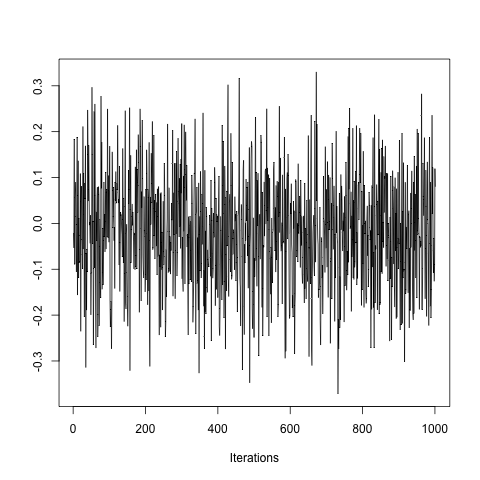

In [27]:
%%R
coda::traceplot(x=coda::as.mcmc(output_advi$beta.1))

# BNN-ARD

In [57]:
!cat examples/bnn-ard/bnn-ard.stan

In [ ]:
!make examples/bnn-ard/bnn-ard


--- Translating Stan model to C++ code ---
bin/stanc examples/bnn-ard/bnn-ard.stan --o=examples/bnn-ard/bnn-ard.hpp
Model name=bnn_ard_model
Input file=examples/bnn-ard/bnn-ard.stan
Output file=examples/bnn-ard/bnn-ard.hpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan_2.9.0/src -isystem stan_2.9.0/lib/stan_math_2.9.0/ -isystem stan_2.9.0/lib/stan_math_2.9.0/lib/eigen_3.2.4 -isystem stan_2.9.0/lib/stan_math_2.9.0/lib/boost_1.58.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-function -ftemplate-depth-256    -O3 -o examples/bnn-ard/bnn-ard src/cmdstan/main.cpp -include examples/bnn-ard/bnn-ard.hpp 


In [ ]:
start = time.time()
!examples/bnn-ard/bnn-ard sample data file=examples/dorothea/dorotheabnn.data.R output file=bnn-ard_dorothea_nuts.csv 
end = time.time()

print end-start

 method = sample (Default)
   sample
     num_samples = 1000 (Default)
     num_warmup = 1000 (Default)
     save_warmup = 0 (Default)
     thin = 1 (Default)
     adapt
       engaged = 1 (Default)
       gamma = 0.050000000000000003 (Default)
       delta = 0.80000000000000004 (Default)
       kappa = 0.75 (Default)
       t0 = 10 (Default)
       init_buffer = 75 (Default)
       term_buffer = 50 (Default)
       window = 25 (Default)
     algorithm = hmc (Default)
       hmc
         engine = nuts (Default)
           nuts
             max_depth = 10 (Default)
         metric = diag_e (Default)
         stepsize = 1 (Default)
         stepsize_jitter = 0 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorotheabnn.data.R
 init = 2 (Default)
 random
   seed = 1518552829
 output
   file = bnn-ard_dorothea_nuts.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


Gradient evaluation took 0.036567 seconds
1000 transitions using 10 leapfrog steps per transition 

In [16]:
%%R
output_nuts <- read_stan_csv("bnn-ard_dorothea_nuts.csv")



log_lik <- extract_log_lik(output_nuts) # see ?extract_log_lik


print(loo(log_lik))
print(waic(log_lik))

print(summary(extract_log_lik(output_nuts, "average_error")))


Error in scan(file, what, nmax, sep, dec, quote, skip, nlines, na.strings,  : 
  scan() expected 'a real', got '-0.0952.183'


/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in scan(file, what, nmax, sep, dec, quote, skip, nlines, na.strings,  : 
  scan() expected 'a real', got '-0.0952.183'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 403 (50.4%) Pareto k estimates between 0.5 and 1 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 151 (18.9%) Pareto k estimates greater than 1 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 4: 54 (6.8%) p_waic estimates greater than 0.4.
We recommend trying loo() instead. 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 5: 
  re

In [12]:
start = time.time()
!examples/bnn-ard/bnn-ard variational data file=examples/dorothea/dorotheabnn.data.R output file=bnn-ard_dorothea_advi.csv 
end = time.time()

print end-start

 method = variational
   variational
     algorithm = meanfield (Default)
       meanfield
     iter = 10000 (Default)
     grad_samples = 1 (Default)
     elbo_samples = 100 (Default)
     eta = 1 (Default)
     adapt
       engaged = 1 (Default)
       iter = 50 (Default)
     tol_rel_obj = 0.01 (Default)
     eval_elbo = 100 (Default)
     output_samples = 1000 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorotheabnn.data.R
 init = 2 (Default)
 random
   seed = 1461752871
 output
   file = bnn-ard_dorothea_advi.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.015022 seconds
1000 iterations under these settings should take 15.022 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 25

In [13]:
%%R
output_advi <- read_one_stan_csv("bnn-ard_dorothea_advi.csv")
#head(output_advi)
col_nb <- grep("log_lik", names(output_advi))
log_lik <- as.matrix(output_advi[,col_nb])
#head(as.matrix(log_lik))
print(loo(log_lik))
print(waic(log_lik))
print(summary(output_advi$average_error))

Computed from 1001 by 800 log-likelihood matrix

         Estimate   SE
elpd_loo   -268.4 19.7
p_loo        12.8  1.2
looic       536.9 39.4

All Pareto k estimates OK (k < 0.5)
Computed from 1001 by 800 log-likelihood matrix

          Estimate   SE
elpd_waic   -268.4 19.7
p_waic        12.8  1.2
waic         536.9 39.5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5016 


# GP

In [ ]:
!make examples/gp/gp

In [3]:
start = time.time()
!examples/gp/gp sample data file=examples/dorothea/dorotheagp.data.R output file=gp_dorothea_nuts.csv 
end = time.time()

print end-start

 method = sample (Default)
   sample
     num_samples = 1000 (Default)
     num_warmup = 1000 (Default)
     save_warmup = 0 (Default)
     thin = 1 (Default)
     adapt
       engaged = 1 (Default)
       gamma = 0.050000000000000003 (Default)
       delta = 0.80000000000000004 (Default)
       kappa = 0.75 (Default)
       t0 = 10 (Default)
       init_buffer = 75 (Default)
       term_buffer = 50 (Default)
       window = 25 (Default)
     algorithm = hmc (Default)
       hmc
         engine = nuts (Default)
           nuts
             max_depth = 10 (Default)
         metric = diag_e (Default)
         stepsize = 1 (Default)
         stepsize_jitter = 0 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorotheagp.data.R
 init = 2 (Default)
 random
   seed = 1505096921
 output
   file = gp_dorothea_nuts.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


Gradient evaluation took 0.472814 seconds
1000 transitions using 10 leapfrog steps per transition would 

In [4]:
%%R
output_nuts <- read_stan_csv("gp_dorothea_nuts.csv")



log_lik <- extract_log_lik(output_nuts) # see ?extract_log_lik


print(loo(log_lik))
print(waic(log_lik))

print(summary(extract_log_lik(output_nuts, "average_error")))


Error in extract_log_lik(output_nuts) : Please load the 'rstan' package.


/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in extract_log_lik(output_nuts) : Please load the 'rstan' package.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In FUN(X[[i]], ...) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  line with "Elapsed Time" not found

  res 

In [ ]:
start = time.time()
!examples/gp/gp variational data file=examples/dorothea/dorotheagp.data.R output file=gp_dorothea_advi.csv 
end = time.time()

print end-start

 method = variational
   variational
     algorithm = meanfield (Default)
       meanfield
     iter = 10000 (Default)
     grad_samples = 1 (Default)
     elbo_samples = 100 (Default)
     eta = 1 (Default)
     adapt
       engaged = 1 (Default)
       iter = 50 (Default)
     tol_rel_obj = 0.01 (Default)
     eval_elbo = 100 (Default)
     output_samples = 1000 (Default)
 id = 0 (Default)
 data
   file = examples/dorothea/dorotheagp.data.R
 init = 2 (Default)
 random
   seed = 1513215460
 output
   file = gp_dorothea_advi.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)



In [ ]:
%%R
output_advi <- read_one_stan_csv("gp_dorothea_advi.csv")
#head(output_advi)
col_nb <- grep("log_lik", names(output_advi))
log_lik <- as.matrix(output_advi[,col_nb])
#head(as.matrix(log_lik))
print(loo(log_lik))
print(waic(log_lik))
print(summary(output_advi$average_error))